# Phase 1: Leaky Integrate-and-Fire (LIF) Neuron Model
## MATH 456 Final Project
### Bridging Biological Neurons and Artificial Activations

**Author:** Helektra Katsoulakis  
**Date:** December 2025

---

## Phase 1 Objectives:
1. Implement the LIF differential equation
2. Define biologically realistic parameters
3. Simulate using Euler method
4. Generate F-I curve (firing rate vs. input current)
5. Perform mathematical analysis (non-dimensionalization, rheobase)
6. Create visualizations (voltage traces, spike rasters)

---

## 1.1 Setup and Imports

In [31]:
# Core imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# Set random seed for reproducibility
np.random.seed(42)

print("✓ All imports successful!")

✓ All imports successful!


## 1.2 The LIF Model: Mathematical Background

The Leaky Integrate-and-Fire (LIF) model describes subthreshold membrane potential dynamics:

$$C_m \frac{dV}{dt} = -g_L(V - E_L) + I_{in}$$

Dividing by $g_L$ gives the standard form:

$$\tau_m \frac{dV}{dt} = -(V - E_L) + \frac{I_{in}}{g_L}$$

**Variables:**
- $V(t)$ = membrane potential (mV)
- $C_m$ = membrane capacitance (μF/cm² or pF)
- $g_L$ = leak conductance (mS/cm² or nS)
- $E_L$ = resting/leak reversal potential (mV)
- $\tau_m = C_m/g_L$ = membrane time constant (ms)
- $I_{in}$ = input current (pA)

**Spike mechanism:**
- When $V \geq V_{th}$ (threshold), the neuron "fires"
- $V$ is reset to $V_{reset}$
- The neuron enters a refractory period $\tau_{ref}$

## 1.3 Define LIF Parameters

In [32]:
def default_pars(**kwargs):
    pars = {}
    
    # ===========================================
    # NEURON PARAMETERS (biologically realistic)
    # ===========================================
    pars['V_th'] = -55.0      # Spike threshold [mV]
    pars['V_reset'] = -75.0   # Reset potential [mV]
    pars['E_L'] = -75.0       # Leak reversal potential (resting) [mV]
    pars['V_init'] = -75.0    # Initial membrane potential [mV]
    
    pars['tau_m'] = 10.0      # Membrane time constant [ms]
    pars['g_L'] = 10.0        # Leak conductance [nS]
    pars['C_m'] = pars['tau_m'] * pars['g_L']  # Capacitance [pF] (derived: C = τ × g)
    
    pars['tref'] = 2.0        # Refractory period [ms]
    
    # ===========================================
    # SIMULATION PARAMETERS
    # ===========================================
    pars['T'] = 500.0         # Total simulation time [ms]
    pars['dt'] = 0.1          # Time step [ms]
    
    # Override with any custom parameters
    for k in kwargs:
        pars[k] = kwargs[k]
    
    # Create time vector
    pars['range_t'] = np.arange(0, pars['T'], pars['dt'])
    
    return pars

# Initialize and display parameters
pars = default_pars()

print("=" * 55)
print("LIF NEURON PARAMETERS")
print("=" * 55)
print(f"{'Parameter':<35} {'Value':<15} {'Unit'}")
print("-" * 55)
print(f"{'Membrane time constant (τ_m)':<35} {pars['tau_m']:<15} ms")
print(f"{'Leak conductance (g_L)':<35} {pars['g_L']:<15} nS")
print(f"{'Membrane capacitance (C_m)':<35} {pars['C_m']:<15} pF")
print(f"{'Resting potential (E_L)':<35} {pars['E_L']:<15} mV")
print(f"{'Spike threshold (V_th)':<35} {pars['V_th']:<15} mV")
print(f"{'Reset potential (V_reset)':<35} {pars['V_reset']:<15} mV")
print(f"{'Refractory period (τ_ref)':<35} {pars['tref']:<15} ms")
print("-" * 55)
print(f"{'Simulation time (T)':<35} {pars['T']:<15} ms")
print(f"{'Time step (dt)':<35} {pars['dt']:<15} ms")
print(f"{'Number of time points':<35} {len(pars['range_t']):<15}")
print("=" * 55)

LIF NEURON PARAMETERS
Parameter                           Value           Unit
-------------------------------------------------------
Membrane time constant (τ_m)        10.0            ms
Leak conductance (g_L)              10.0            nS
Membrane capacitance (C_m)          100.0           pF
Resting potential (E_L)             -75.0           mV
Spike threshold (V_th)              -55.0           mV
Reset potential (V_reset)           -75.0           mV
Refractory period (τ_ref)           2.0             ms
-------------------------------------------------------
Simulation time (T)                 500.0           ms
Time step (dt)                      0.1             ms
Number of time points               5000           


## 1.4 Implement the LIF Simulation (Euler Method)

We use the **Euler method** for numerical integration:

$$V(t + dt) = V(t) + \frac{dt}{\tau_m} \left[ -(V(t) - E_L) + \frac{I_{in}}{g_L} \right]$$

In [33]:
def run_LIF(pars, Iinj):
    """
    Simulate the LIF neuron dynamics with external input current.
    Uses Euler method for numerical integration.
    
    Args:
        pars:  parameter dictionary
        Iinj:  input current [pA]. Can be a scalar or array.
    
    Returns:
        v:         membrane potential trace [mV]
        rec_spikes: array of spike times [ms]
    """
    # Extract parameters
    V_th, V_reset = pars['V_th'], pars['V_reset']
    tau_m, g_L = pars['tau_m'], pars['g_L']
    V_init, E_L = pars['V_init'], pars['E_L']
    dt, range_t = pars['dt'], pars['range_t']
    tref = pars['tref']
    
    Lt = len(range_t)  # Number of time steps
    
    # Initialize voltage array
    v = np.zeros(Lt)
    v[0] = V_init
    
    # Set up input current (make it an array if it's a scalar)
    if np.isscalar(Iinj):
        Iinj = Iinj * np.ones(Lt)
    else:
        Iinj = np.array(Iinj)
    
    # Track spikes and refractory state
    rec_spikes = []  # Spike times
    tr = 0.0         # Refractory counter
    
    # ===========================================
    # MAIN SIMULATION LOOP (Euler integration)
    # ===========================================
    for it in range(Lt - 1):
        
        # Check if in refractory period
        if tr > 0:
            v[it] = V_reset      # Clamp voltage to reset
            tr -= 1              # Decrement refractory counter
        
        # Check for spike
        elif v[it] >= V_th:
            rec_spikes.append(it)        # Record spike time index
            v[it] = V_reset              # Reset voltage
            tr = tref / dt               # Start refractory period
        
        # =============================================
        # EULER METHOD: dV/dt = (1/τ_m) × [-(V - E_L) + I/g_L]
        # =============================================
        dv = (dt / tau_m) * (-(v[it] - E_L) + Iinj[it] / g_L)
        
        # Update membrane potential
        v[it + 1] = v[it] + dv
    
    # Convert spike indices to times [ms]
    rec_spikes = np.array(rec_spikes) * dt
    
    return v, rec_spikes

print("✓ LIF simulation function defined!")

✓ LIF simulation function defined!


## 1.5 Plotting Helper Functions

In [34]:
def plot_volt_trace(pars, v, sp, title="LIF Neuron Membrane Potential", ax=None):
    """
    Plot the membrane potential trace with spikes.
    """
    V_th = pars['V_th']
    dt = pars['dt']
    
    # Create a copy and add "spikes" for visualization
    v_plot = v.copy()
    if len(sp) > 0:
        sp_idx = (sp / dt).astype(int)
        sp_idx = sp_idx[sp_idx < len(v_plot)]
        v_plot[sp_idx] = 20  # Add visual spike
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 4))
    
    ax.plot(pars['range_t'], v_plot, 'b', linewidth=1.0, label='Membrane potential')
    ax.axhline(V_th, color='r', linestyle='--', linewidth=1.5, 
               label=f'Threshold ($V_{{th}}$ = {V_th} mV)')
    ax.axhline(pars['E_L'], color='gray', linestyle=':', linewidth=1.0, 
               alpha=0.7, label=f'Resting ($E_L$ = {pars["E_L"]} mV)')
    
    ax.set_xlabel('Time (ms)', fontsize=12)
    ax.set_ylabel('Membrane Potential (mV)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(loc='upper right')
    ax.set_ylim([-80, 30])
    ax.grid(True, alpha=0.3)
    
    return ax

print("✓ Plotting functions defined!")

✓ Plotting functions defined!


## 1.6 Test the LIF Model with Different Input Currents

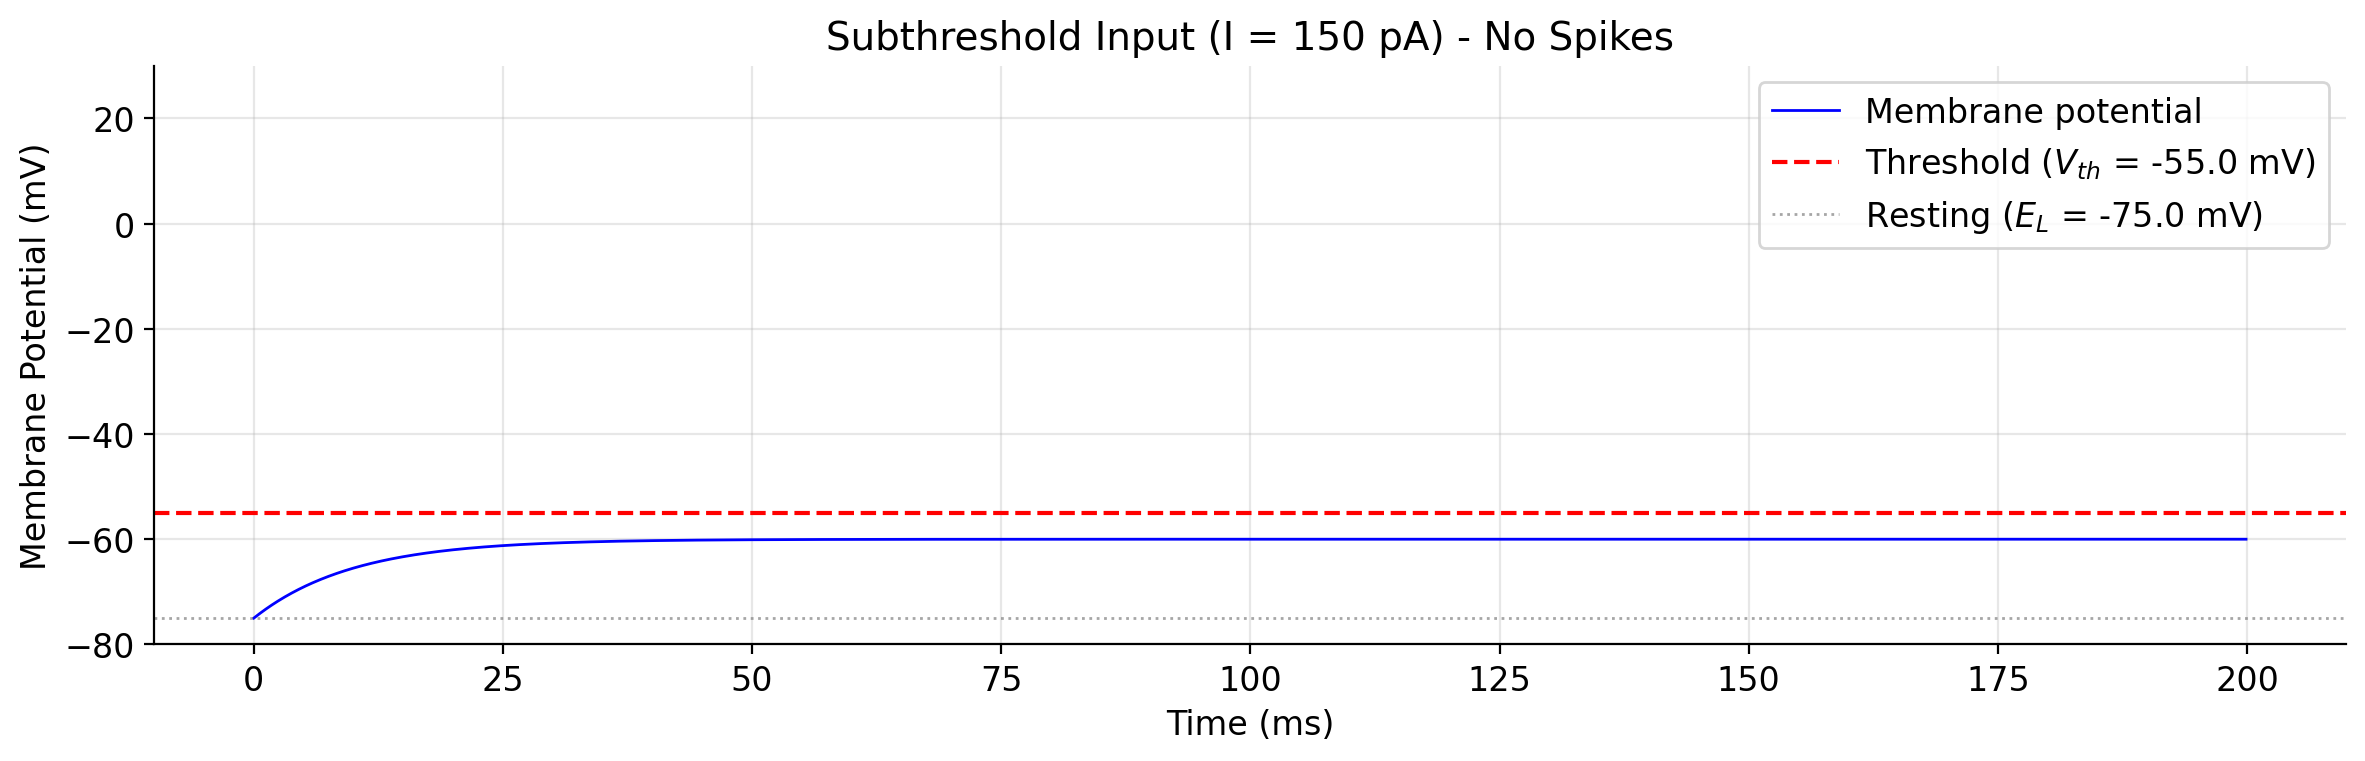

Number of spikes: 0


In [35]:
# Test 1: Subthreshold current (no spikes)
pars = default_pars(T=200)
v_sub, sp_sub = run_LIF(pars, Iinj=150)

fig, ax = plt.subplots(figsize=(12, 4))
plot_volt_trace(pars, v_sub, sp_sub, 
                title="Subthreshold Input (I = 150 pA) - No Spikes", ax=ax)
plt.tight_layout()
plt.show()

print(f"Number of spikes: {len(sp_sub)}")

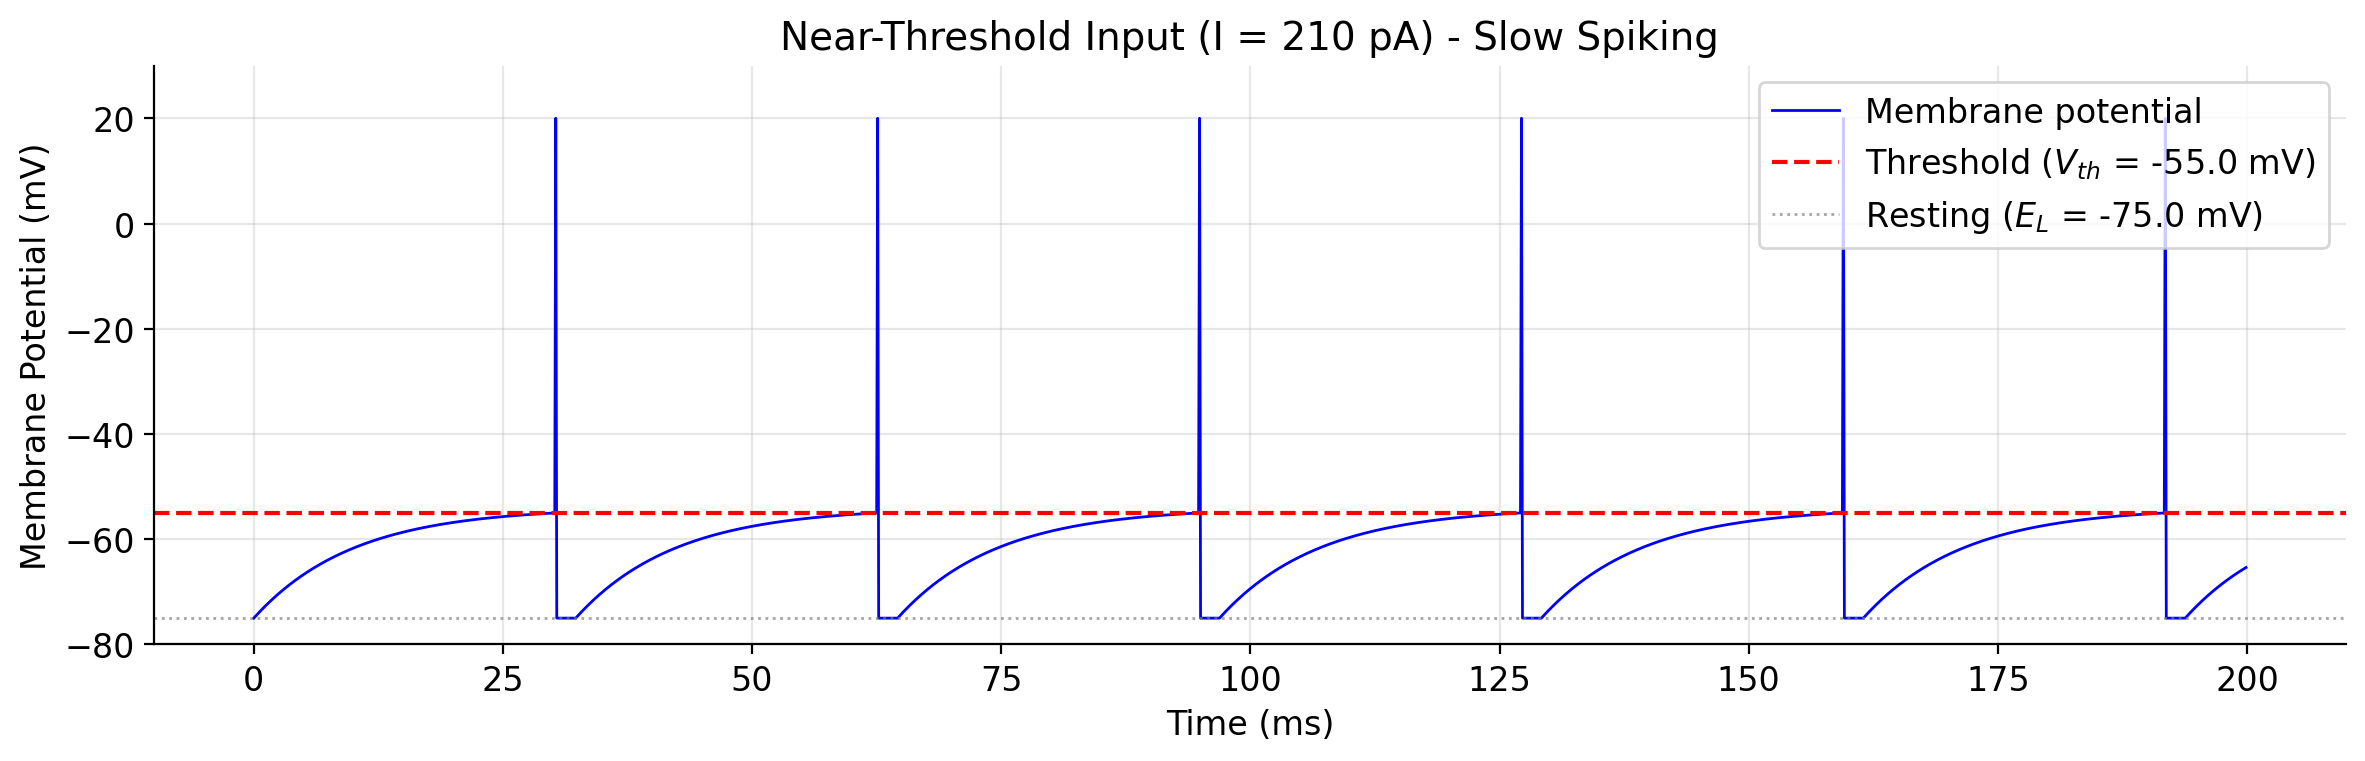

Number of spikes: 6
Firing rate: 30.0 Hz


In [36]:
# Test 2: Just above threshold (slow spiking)
pars = default_pars(T=200)
v_thresh, sp_thresh = run_LIF(pars, Iinj=210)

fig, ax = plt.subplots(figsize=(12, 4))
plot_volt_trace(pars, v_thresh, sp_thresh, 
                title="Near-Threshold Input (I = 210 pA) - Slow Spiking", ax=ax)
plt.tight_layout()
plt.show()

firing_rate = len(sp_thresh) / (pars['T'] / 1000)
print(f"Number of spikes: {len(sp_thresh)}")
print(f"Firing rate: {firing_rate:.1f} Hz")

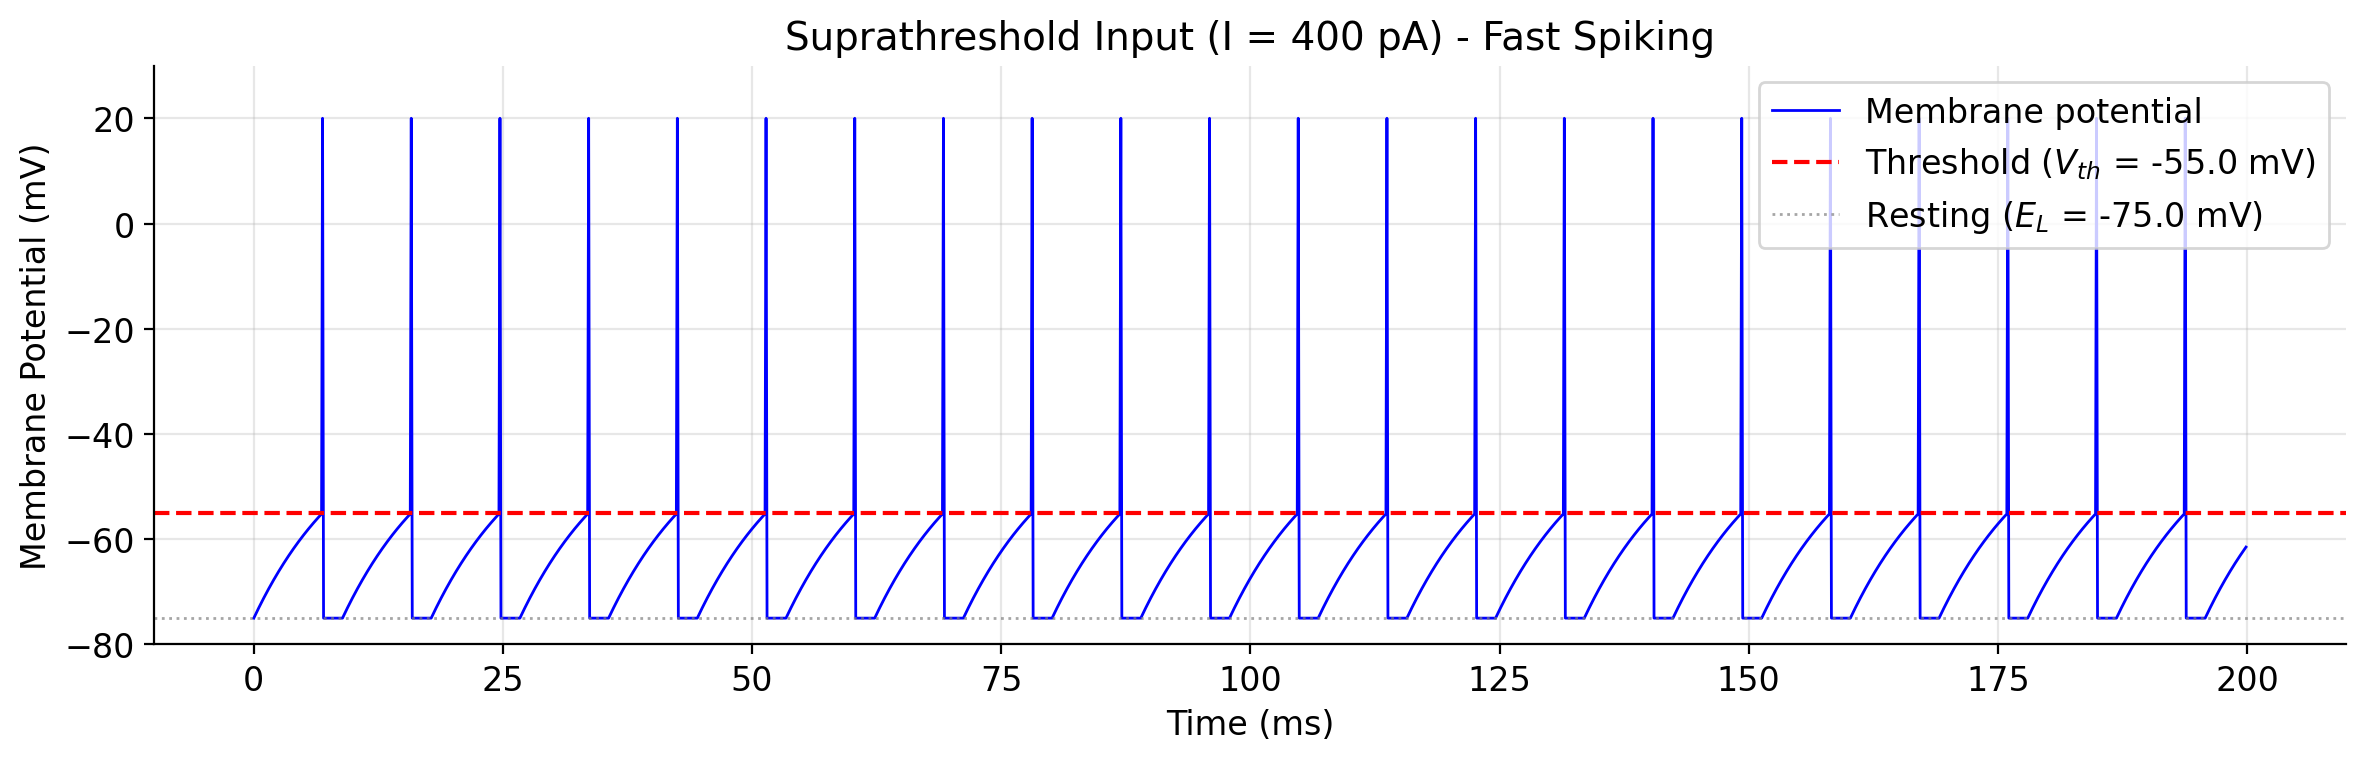

Number of spikes: 22
Firing rate: 110.0 Hz


In [37]:
# Test 3: Strong suprathreshold current (fast spiking)
pars = default_pars(T=200)
v_supra, sp_supra = run_LIF(pars, Iinj=400)

fig, ax = plt.subplots(figsize=(12, 4))
plot_volt_trace(pars, v_supra, sp_supra, 
                title="Suprathreshold Input (I = 400 pA) - Fast Spiking", ax=ax)
plt.tight_layout()
plt.show()

firing_rate = len(sp_supra) / (pars['T'] / 1000)
print(f"Number of spikes: {len(sp_supra)}")
print(f"Firing rate: {firing_rate:.1f} Hz")

## 1.7 Compare Multiple Input Currents Side-by-Side

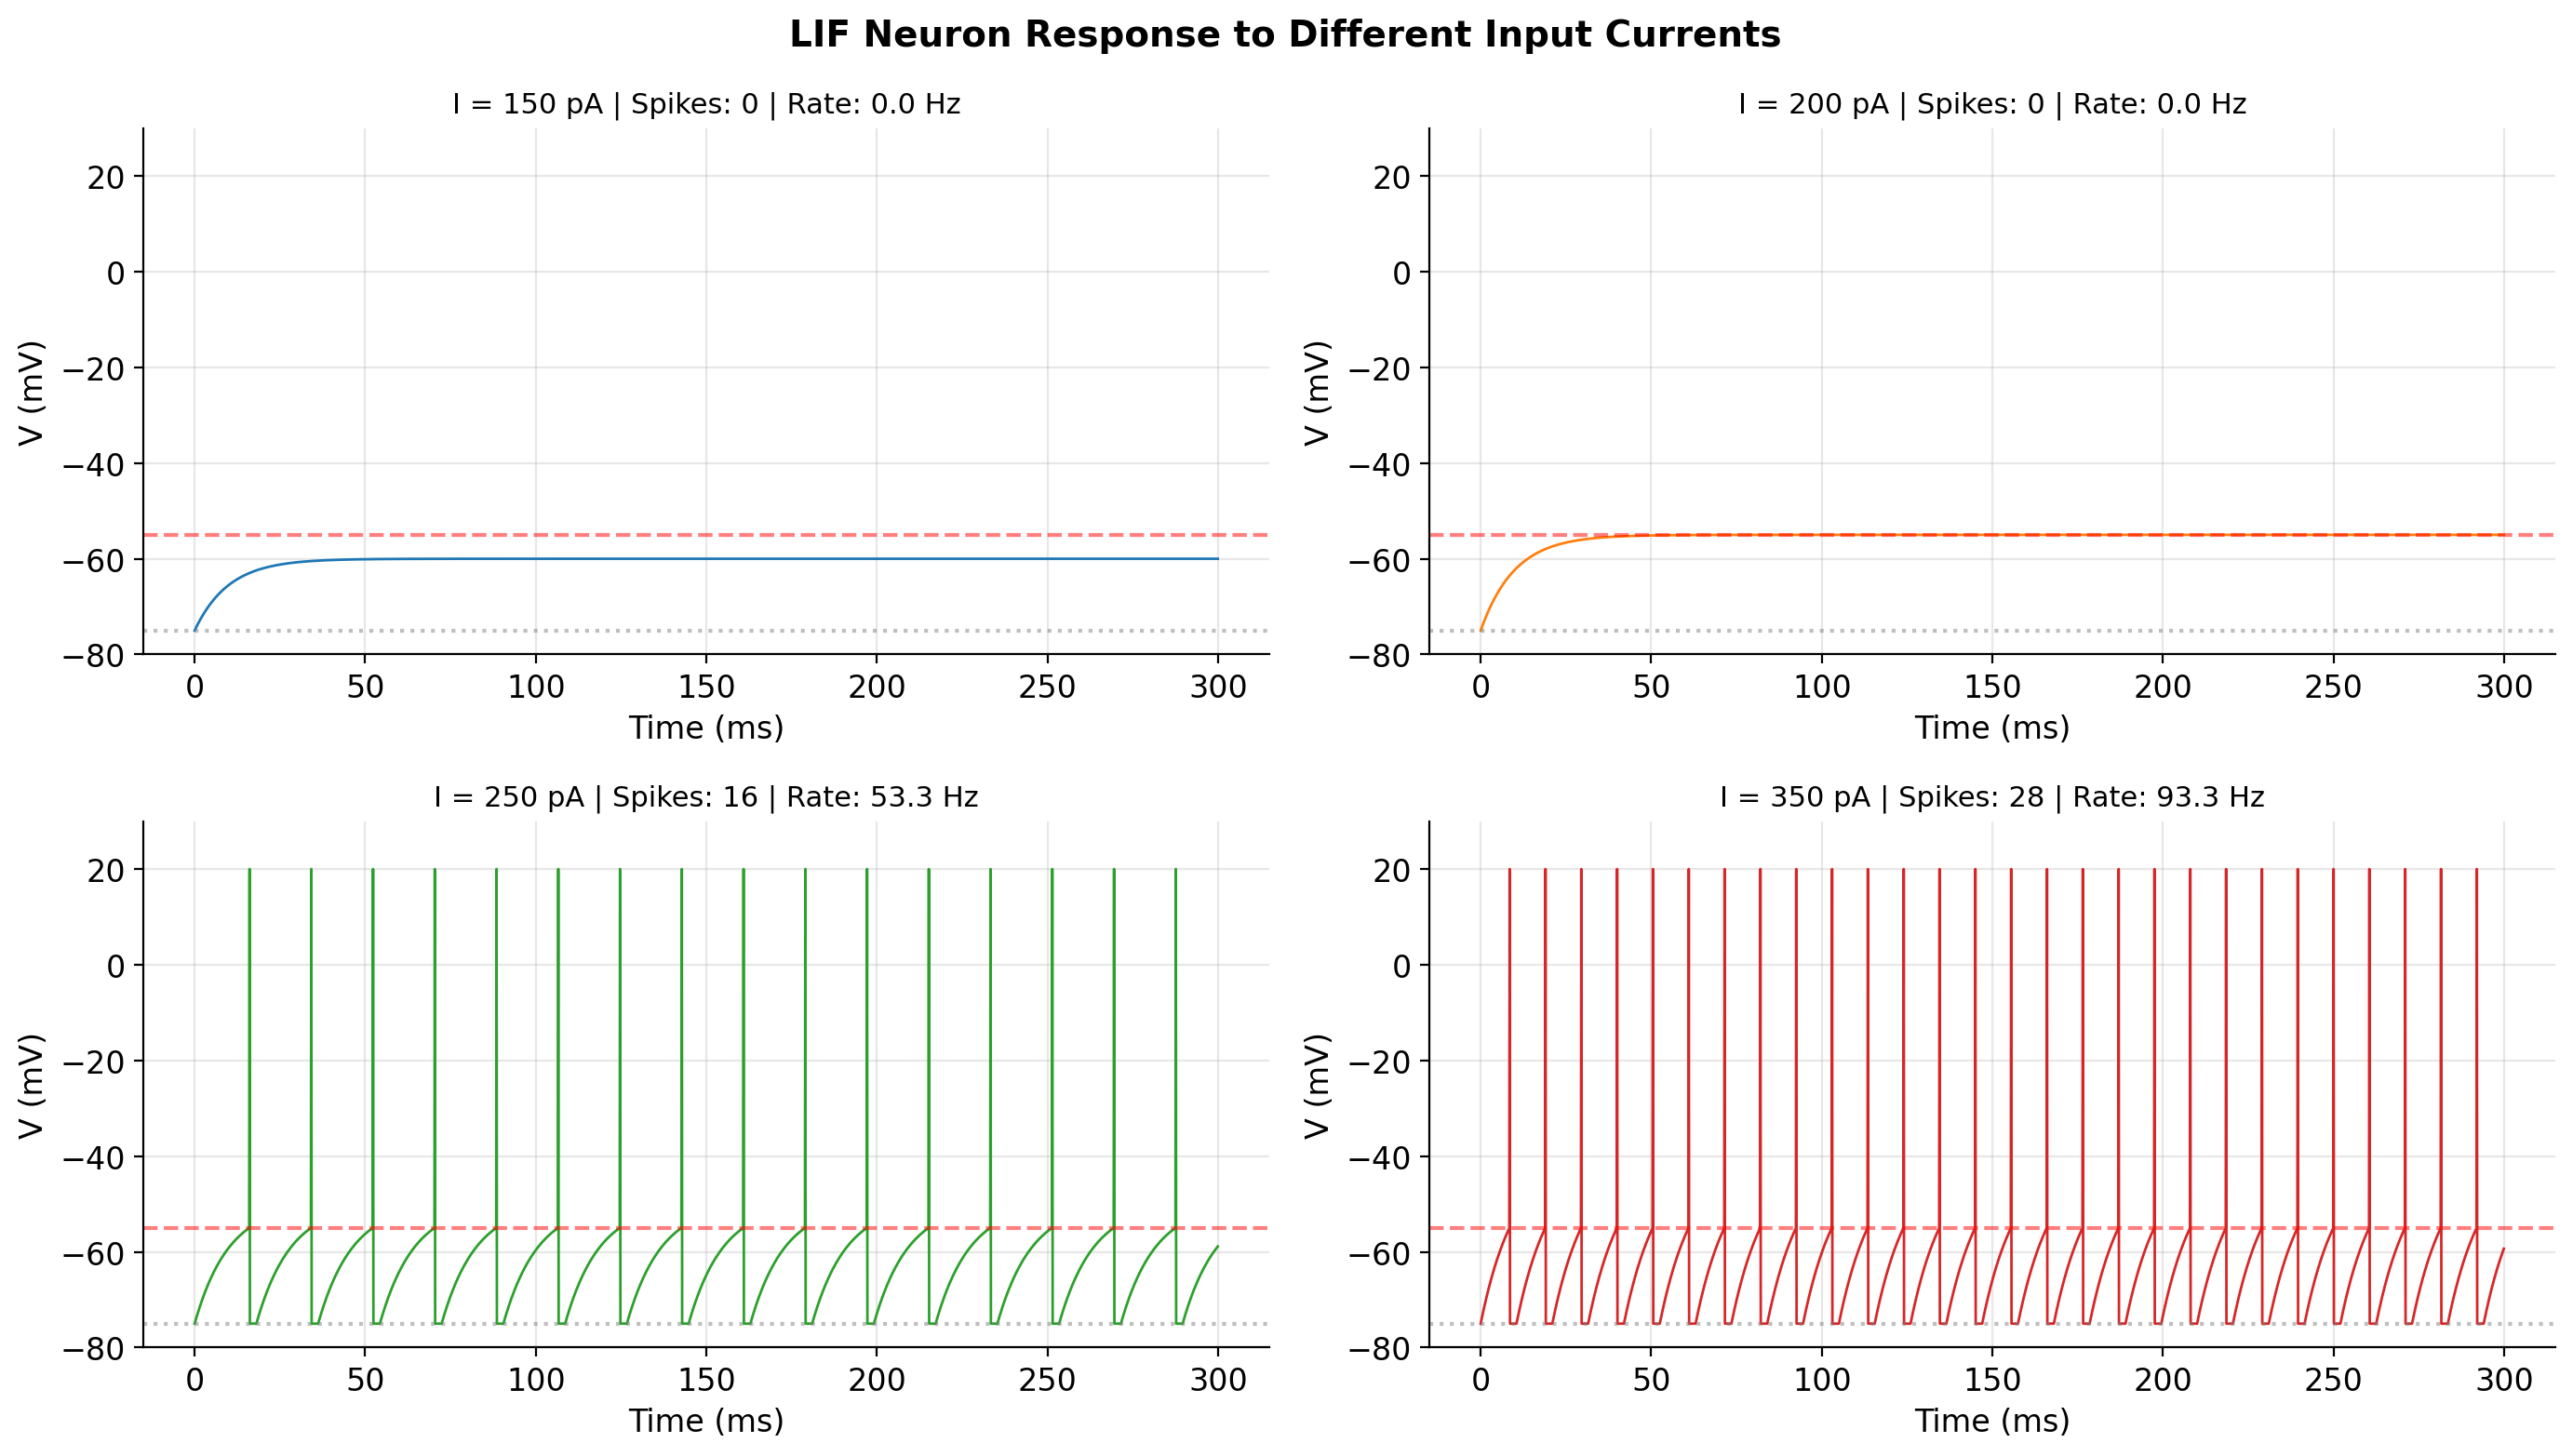

In [38]:
# Compare different input currents
pars = default_pars(T=300)
currents = [150, 200, 250, 350]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for idx, (I_in, color) in enumerate(zip(currents, colors)):
    v, sp = run_LIF(pars, Iinj=I_in)
    
    # Add spikes for visualization
    v_plot = v.copy()
    if len(sp) > 0:
        sp_idx = (sp / pars['dt']).astype(int)
        sp_idx = sp_idx[sp_idx < len(v_plot)]
        v_plot[sp_idx] = 20
    
    ax = axes[idx]
    ax.plot(pars['range_t'], v_plot, color=color, linewidth=1.0)
    ax.axhline(pars['V_th'], color='red', linestyle='--', alpha=0.5)
    ax.axhline(pars['E_L'], color='gray', linestyle=':', alpha=0.5)
    
    firing_rate = len(sp) / (pars['T'] / 1000) if len(sp) > 0 else 0
    ax.set_title(f'I = {I_in} pA | Spikes: {len(sp)} | Rate: {firing_rate:.1f} Hz', fontsize=11)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('V (mV)')
    ax.set_ylim([-80, 30])
    ax.grid(True, alpha=0.3)

plt.suptitle('LIF Neuron Response to Different Input Currents', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 1.8 Analytical Derivation: Rheobase Current

The **rheobase** is the minimum constant current required to make the neuron spike.

At steady state ($\frac{dV}{dt} = 0$):

$$0 = -(V_{ss} - E_L) + \frac{I}{g_L}$$

$$V_{ss} = E_L + \frac{I}{g_L}$$

For the neuron to spike, we need $V_{ss} \geq V_{th}$:

$$E_L + \frac{I_{rheo}}{g_L} = V_{th}$$

$$\boxed{I_{rheo} = g_L (V_{th} - E_L)}$$

In [39]:
# Calculate theoretical rheobase
pars = default_pars()

I_rheobase = pars['g_L'] * (pars['V_th'] - pars['E_L'])

print("=" * 60)
print("RHEOBASE CALCULATION")
print("=" * 60)
print(f"\nFormula: I_rheo = g_L × (V_th - E_L)")
print(f"\n         I_rheo = {pars['g_L']} nS × ({pars['V_th']} mV - ({pars['E_L']} mV))")
print(f"         I_rheo = {pars['g_L']} × {pars['V_th'] - pars['E_L']} mV")
print(f"\n>>> Theoretical Rheobase: I_rheo = {I_rheobase:.1f} pA <<<")
print("\n" + "=" * 60)

# Verify with simulation
print("\nVerification by simulation:")
print("-" * 40)
for I_test in [190, 195, 200, 205, 210]:
    v, sp = run_LIF(default_pars(T=500), Iinj=I_test)
    status = "✓ SPIKING" if len(sp) > 0 else "✗ No spikes"
    print(f"  I = {I_test} pA: {status} ({len(sp)} spikes)")

RHEOBASE CALCULATION

Formula: I_rheo = g_L × (V_th - E_L)

         I_rheo = 10.0 nS × (-55.0 mV - (-75.0 mV))
         I_rheo = 10.0 × 20.0 mV

>>> Theoretical Rheobase: I_rheo = 200.0 pA <<<


Verification by simulation:
----------------------------------------
  I = 190 pA: ✗ No spikes (0 spikes)
  I = 195 pA: ✗ No spikes (0 spikes)
  I = 200 pA: ✗ No spikes (0 spikes)
  I = 205 pA: ✓ SPIKING (12 spikes)
  I = 210 pA: ✓ SPIKING (15 spikes)


## 1.9 Generate the F-I Curve (Firing Rate vs. Input Current)

The **F-I curve** is the fundamental input-output function of the neuron.

Computing F-I curve...
✓ Done!


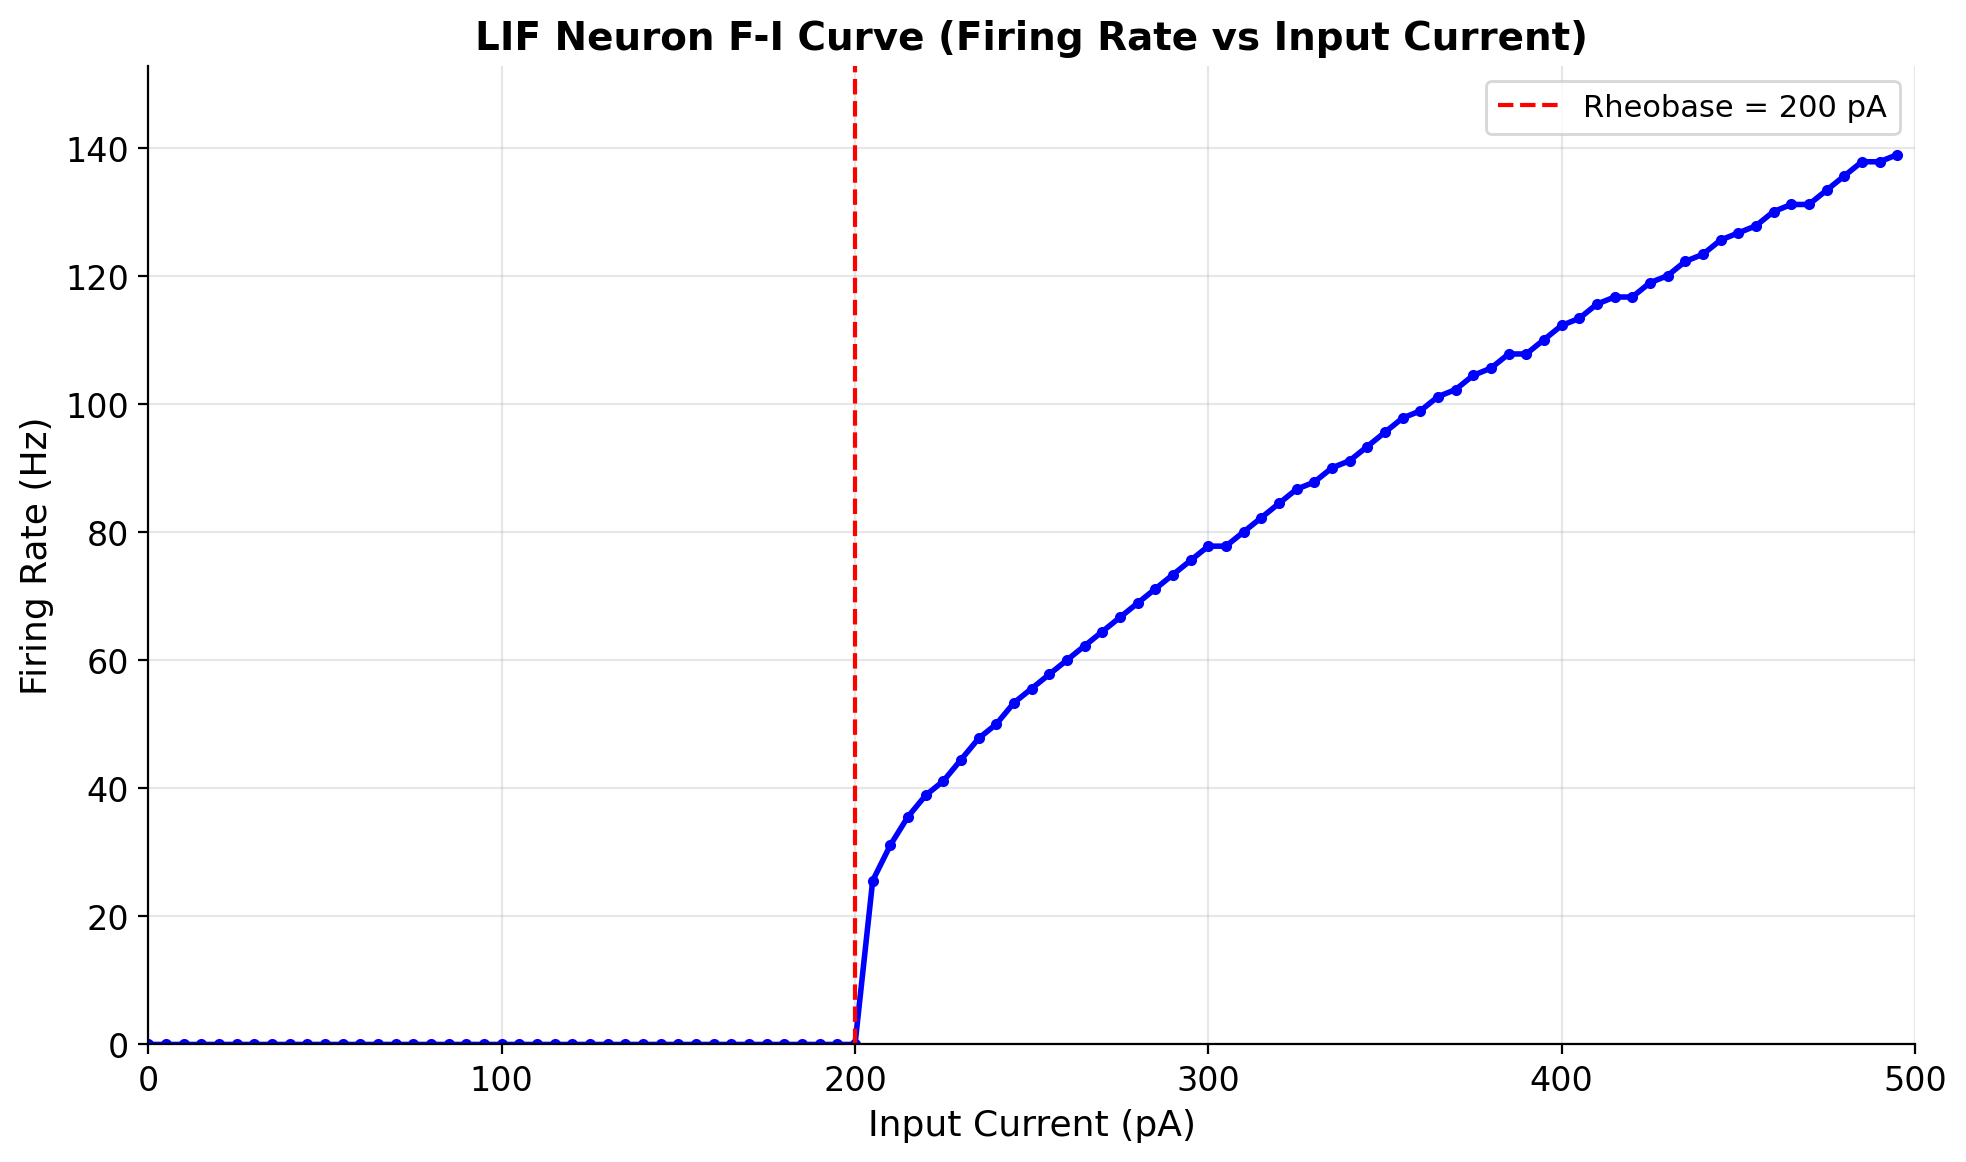


Maximum firing rate: 138.9 Hz at I = 495 pA


In [40]:
def compute_FI_curve(pars, I_range, discard_time=100):
    """
    Compute the F-I curve (firing rate vs input current).
    
    Args:
        pars:         parameter dictionary
        I_range:      array of input currents to test [pA]
        discard_time: initial time to discard for transients [ms]
    
    Returns:
        firing_rates: array of firing rates [Hz]
    """
    firing_rates = []
    
    for I_in in I_range:
        v, sp = run_LIF(pars, Iinj=I_in)
        # v = array pf membrane voltage at each time step 
        # sp = array of spike times (when voltage hit threshold)
        
        # Only count spikes after transient period
        sp_steady = sp[sp > discard_time]
        
        # Compute firing rate (spikes per second)
        effective_time = (pars['T'] - discard_time) / 1000  # Convert to seconds
        rate = len(sp_steady) / effective_time if effective_time > 0 else 0
        firing_rates.append(rate)
    
    return np.array(firing_rates)

# Generate F-I curve
pars = default_pars(T=1000)  # 1 second simulation 
I_range = np.arange(0, 500, 5)  # 0 to 500 pA in steps of 5

print("Computing F-I curve...")
firing_rates = compute_FI_curve(pars, I_range)
print("✓ Done!")

# Plot the F-I curve
plt.figure(figsize=(10, 6))
plt.plot(I_range, firing_rates, 'b-', linewidth=2, marker='o', markersize=3)
plt.axvline(I_rheobase, color='red', linestyle='--', linewidth=1.5, 
            label=f'Rheobase = {I_rheobase:.0f} pA')
plt.xlabel('Input Current (pA)', fontsize=13)
plt.ylabel('Firing Rate (Hz)', fontsize=13)
plt.title('LIF Neuron F-I Curve (Firing Rate vs Input Current)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0, 500])
plt.ylim([0, max(firing_rates) * 1.1])
plt.tight_layout()
plt.show()

print(f"\nMaximum firing rate: {max(firing_rates):.1f} Hz at I = {I_range[np.argmax(firing_rates)]} pA")

## 1.10 Fit Activation Functions to the F-I Curve

Let's see how well common activation functions (ReLU, Sigmoid) can approximate the biological F-I curve.

In [41]:
# Define activation functions for fitting

def relu_func(x, a, b):
    """Scaled and shifted ReLU: f(x) = a * max(0, x - b)"""
    return a * np.maximum(0, x - b)

def sigmoid_func(x, L, k, x0):
    """Sigmoid: f(x) = L / (1 + exp(-k*(x - x0)))"""
    return L / (1 + np.exp(-k * (x - x0)))

# Fit ReLU
try:
    popt_relu, _ = curve_fit(relu_func, I_range, firing_rates, 
                              p0=[0.5, 200], maxfev=5000)
    relu_fit = relu_func(I_range, *popt_relu)
    relu_r2 = 1 - np.sum((firing_rates - relu_fit)**2) / np.sum((firing_rates - np.mean(firing_rates))**2)
    print(f"ReLU fit: a={popt_relu[0]:.4f}, b={popt_relu[1]:.1f}, R²={relu_r2:.4f}")
except Exception as e:
    relu_fit = np.zeros_like(I_range)
    relu_r2 = 0
    print(f"ReLU fit failed: {e}")

# Fit Sigmoid
try:
    popt_sig, _ = curve_fit(sigmoid_func, I_range, firing_rates,
                            p0=[max(firing_rates), 0.02, 250], maxfev=5000)
    sigmoid_fit = sigmoid_func(I_range, *popt_sig)
    sig_r2 = 1 - np.sum((firing_rates - sigmoid_fit)**2) / np.sum((firing_rates - np.mean(firing_rates))**2)
    print(f"Sigmoid fit: L={popt_sig[0]:.1f}, k={popt_sig[1]:.4f}, x0={popt_sig[2]:.1f}, R²={sig_r2:.4f}")
except Exception as e:
    sigmoid_fit = np.zeros_like(I_range)
    sig_r2 = 0
    print(f"Sigmoid fit failed: {e}")

ReLU fit: a=0.4278, b=141.5, R²=0.9784
Sigmoid fit: L=128.8, k=0.0198, x0=282.5, R²=0.9788


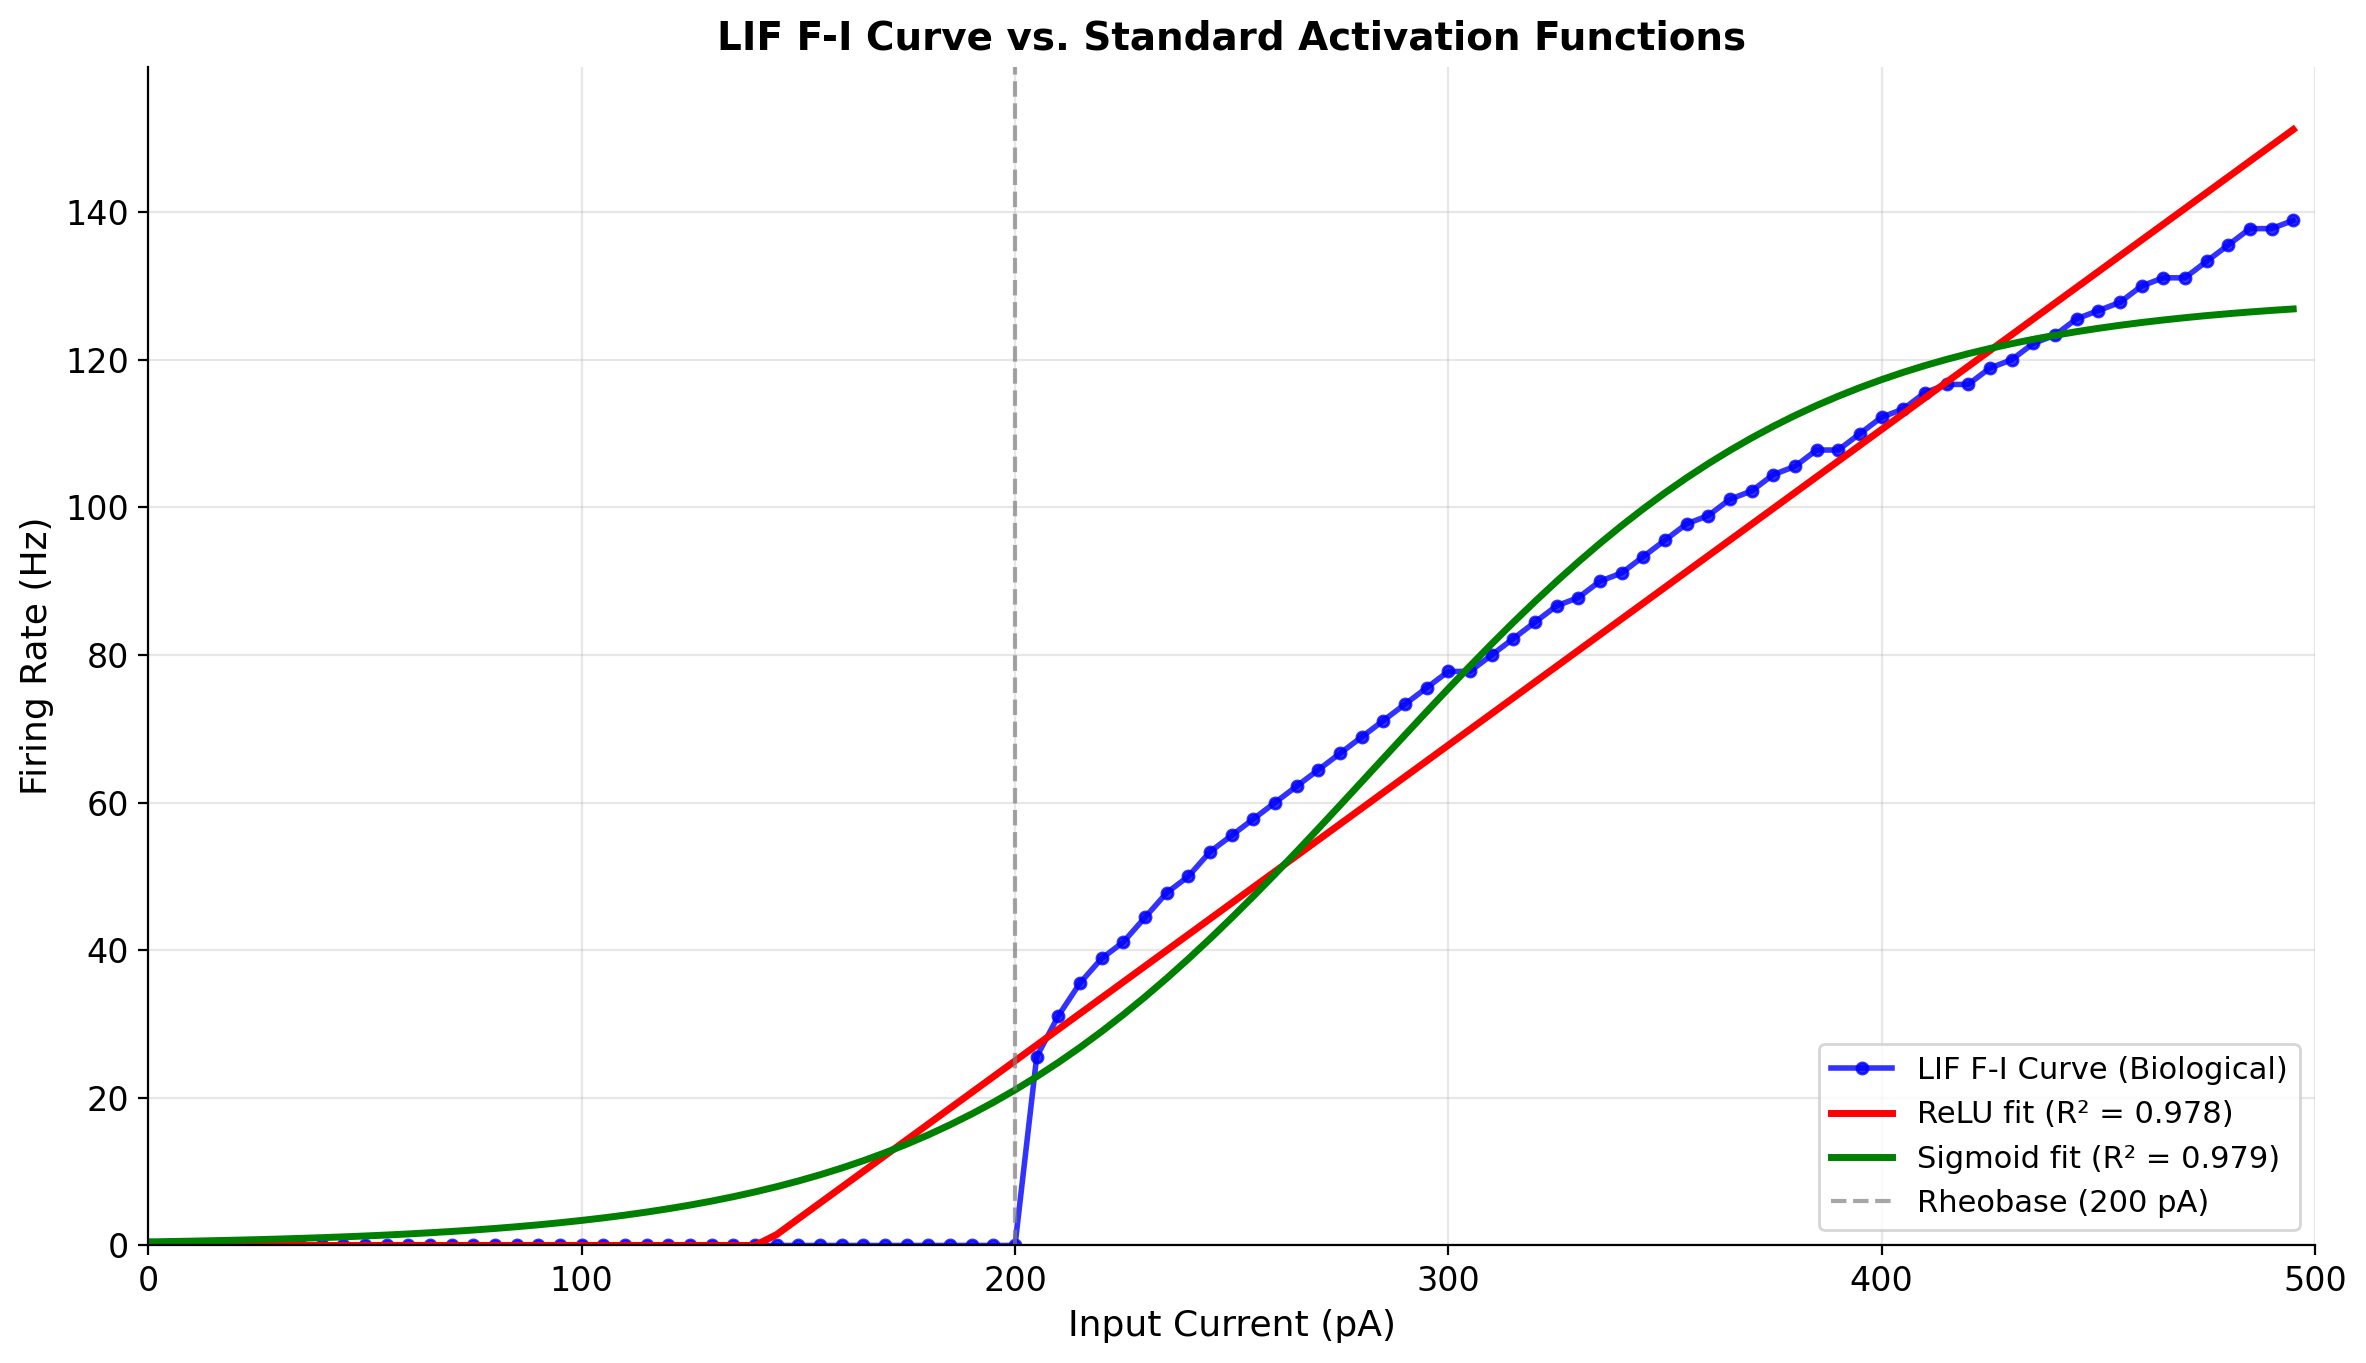


KEY OBSERVATION:
• ReLU R² = 0.9784
• Sigmoid R² = 0.9788

Neither activation function perfectly captures the LIF behavior!
The LIF has a sharp threshold (like ReLU) but also shows
saturation effects at high currents.


In [48]:
# Plot F-I curve with fitted activation functions
plt.figure(figsize=(12, 7))

# LIF F-I curve (ground truth)
plt.plot(I_range, firing_rates, 'bo-', linewidth=2, markersize=4, 
         label='LIF F-I Curve (Biological)', alpha=0.8)

# ReLU fit
plt.plot(I_range, relu_fit, 'r-', linewidth=2.5, 
         label=f'ReLU fit (R² = {relu_r2:.3f})')

# Sigmoid fit
plt.plot(I_range, sigmoid_fit, 'g-', linewidth=2.5, 
         label=f'Sigmoid fit (R² = {sig_r2:.3f})')

# Rheobase line
plt.axvline(I_rheobase, color='gray', linestyle='--', linewidth=1.5, 
            alpha=0.7, label=f'Rheobase ({I_rheobase:.0f} pA)')

plt.xlabel('Input Current (pA)', fontsize=13)
plt.ylabel('Firing Rate (Hz)', fontsize=13)
plt.title('LIF F-I Curve vs. Standard Activation Functions', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3)
plt.xlim([0, 500])
plt.ylim([0, max(firing_rates) * 1.15])
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("KEY OBSERVATION:")
print("="*60)
print(f"• ReLU R² = {relu_r2:.4f}")
print(f"• Sigmoid R² = {sig_r2:.4f}")
print("\nNeither activation function perfectly captures the LIF behavior!")
print("The LIF has a sharp threshold (like ReLU) but also shows")
print("saturation effects at high currents.")

## 1.11 Spike Raster Plot

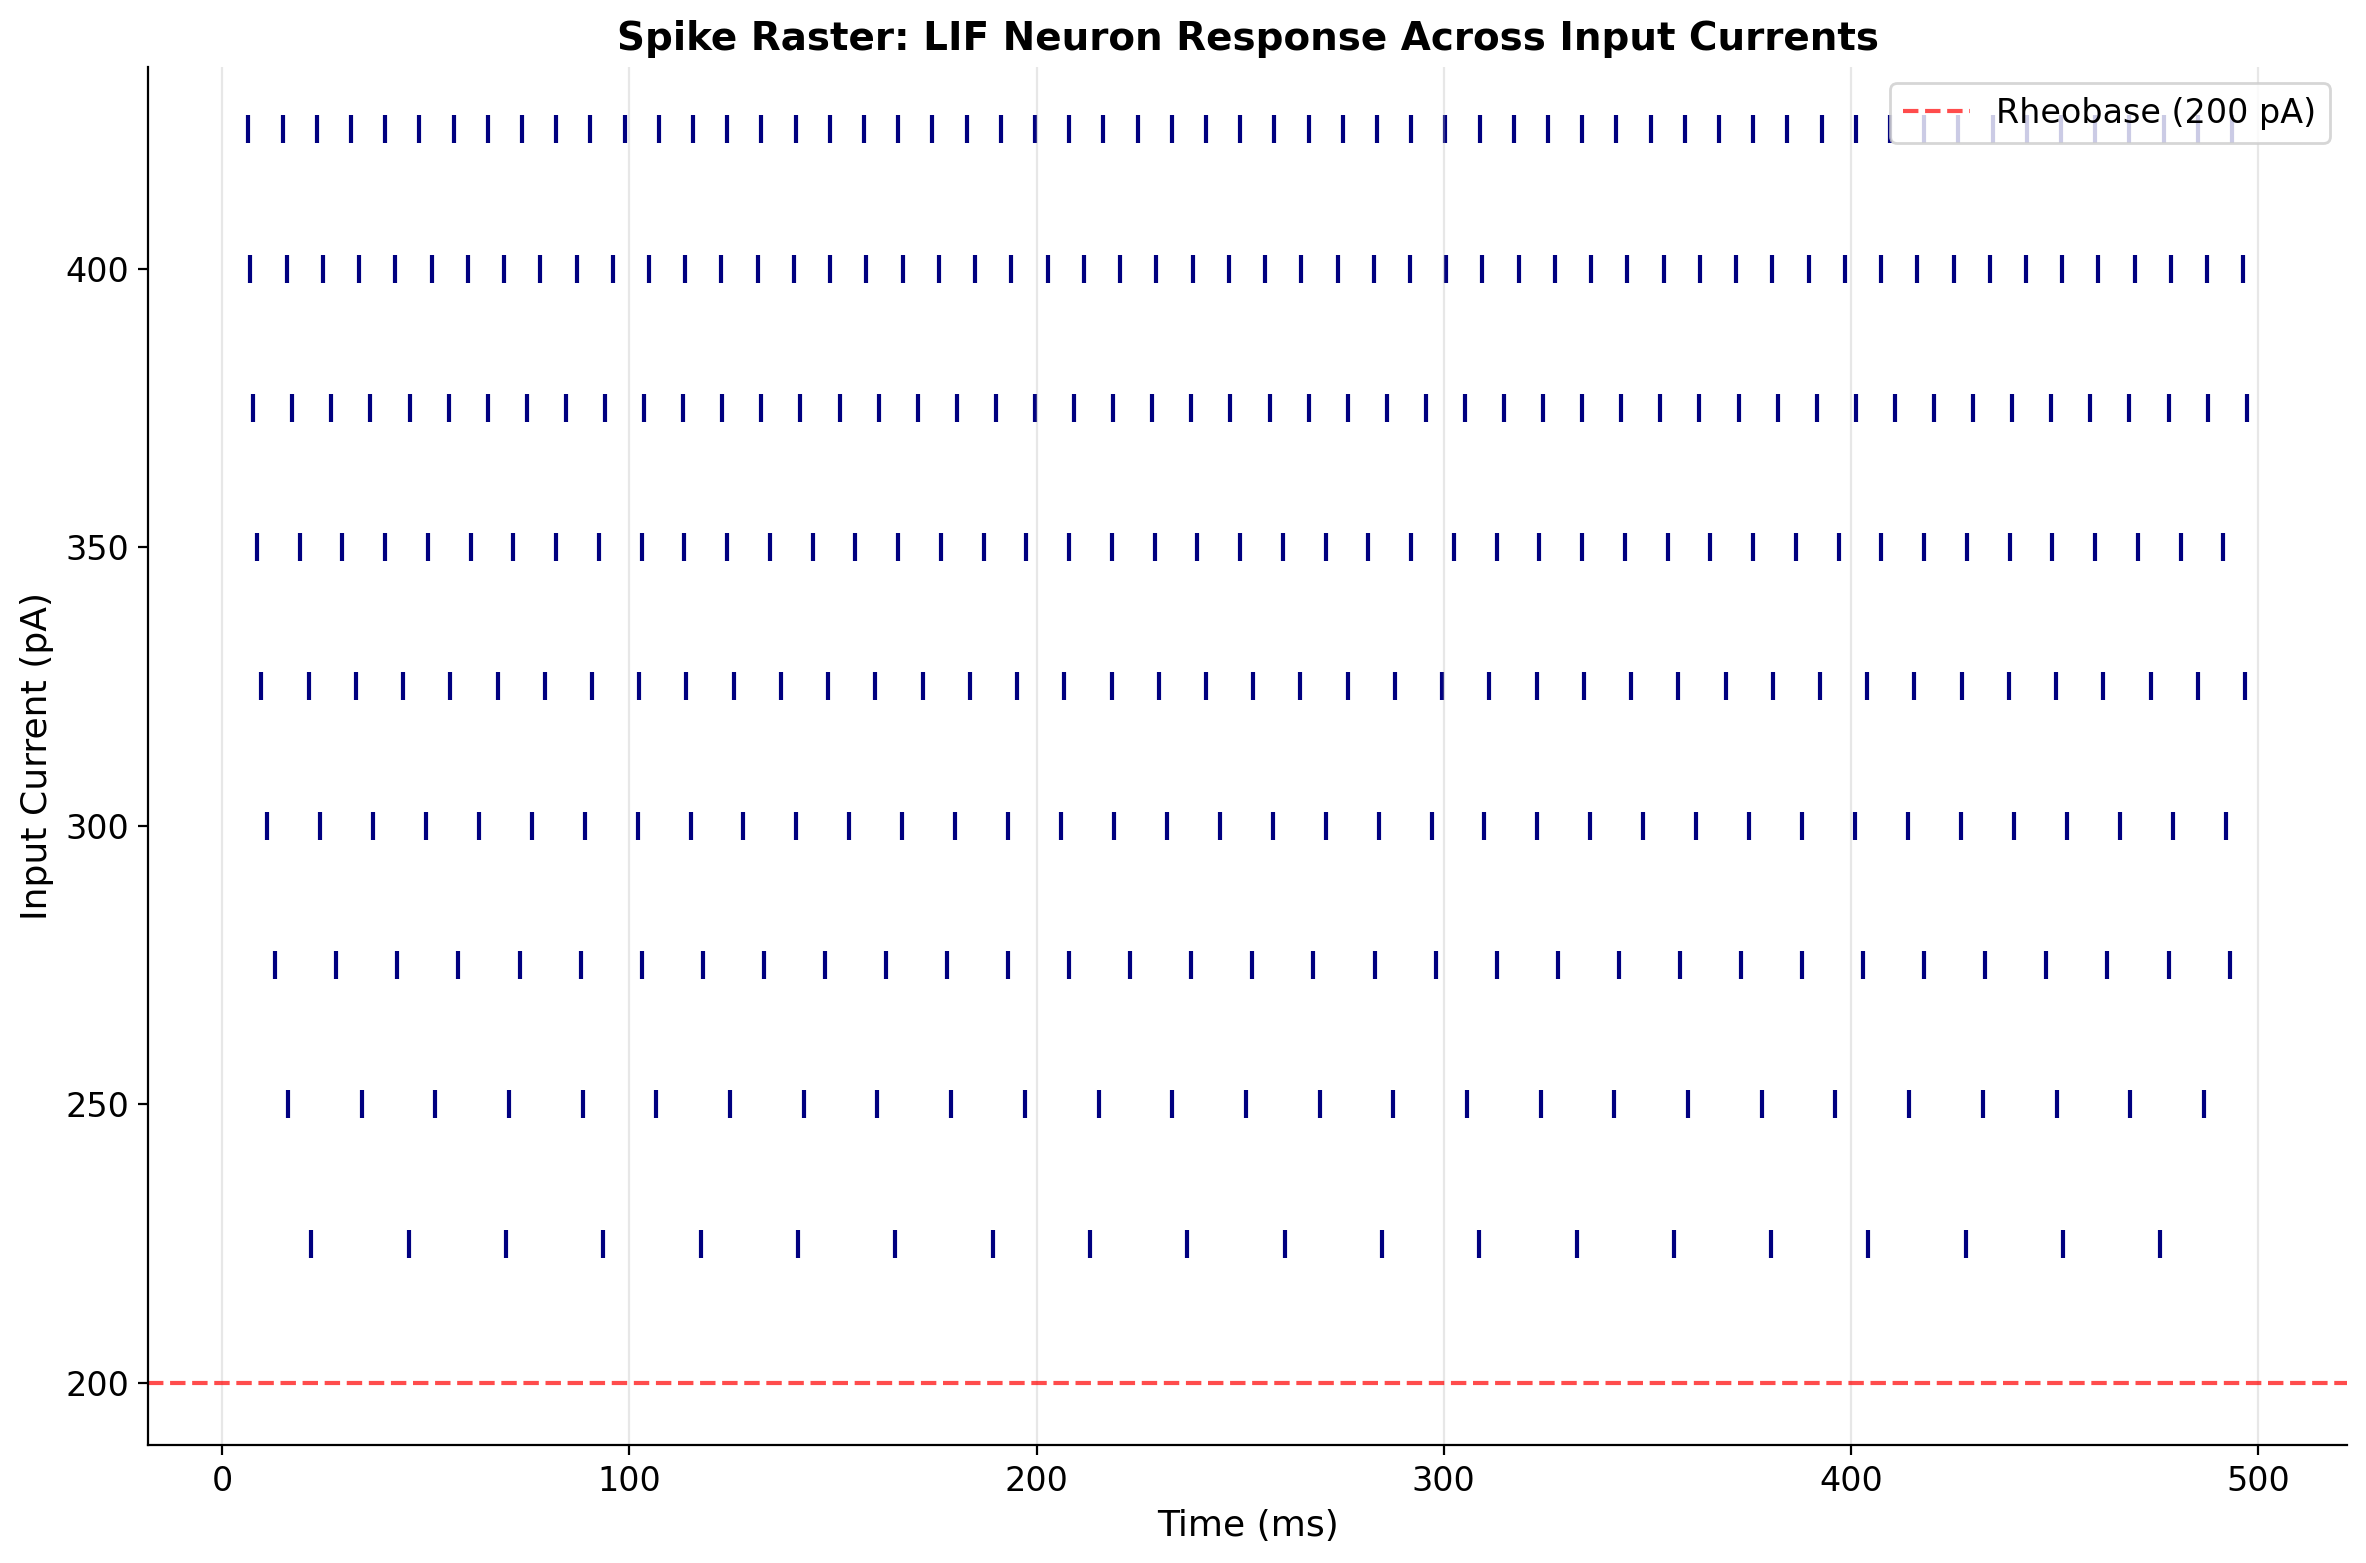

In [43]:
# Generate spike raster for multiple currents
pars = default_pars(T=500)
I_raster = np.arange(150, 450, 25)

plt.figure(figsize=(12, 8))

for idx, I_in in enumerate(I_raster):
    v, sp = run_LIF(pars, Iinj=I_in)
    plt.scatter(sp, np.ones_like(sp) * I_in, marker='|', s=100, c='navy', linewidths=1.5)

plt.axhline(I_rheobase, color='red', linestyle='--', linewidth=1.5, 
            alpha=0.7, label=f'Rheobase ({I_rheobase:.0f} pA)')

plt.xlabel('Time (ms)', fontsize=13)
plt.ylabel('Input Current (pA)', fontsize=13)
plt.title('Spike Raster: LIF Neuron Response Across Input Currents', fontsize=14, fontweight='bold')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 1.12 Non-Dimensionalization (Mathematical Analysis)

Starting from:
$$\tau_m \frac{dV}{dt} = -(V - E_L) + \frac{I}{g_L}$$

Define dimensionless variables:
- $\tilde{t} = t / \tau_m$ (dimensionless time)
- $\tilde{v} = (V - E_L) / (V_{th} - E_L)$ (dimensionless voltage, scaled so threshold = 1)
- $\tilde{i} = I / [g_L(V_{th} - E_L)]$ (dimensionless current, scaled to rheobase)

The equation becomes:
$$\frac{d\tilde{v}}{d\tilde{t}} = -\tilde{v} + \tilde{i}$$

With:
- Threshold at $\tilde{v} = 1$
- Reset at $\tilde{v}_{reset} = (V_{reset} - E_L)/(V_{th} - E_L)$
- Spiking occurs when $\tilde{i} > 1$ (input exceeds rheobase)

In [44]:
# Non-dimensionalized parameters
pars = default_pars()

V_scale = pars['V_th'] - pars['E_L']  # Voltage scale
I_scale = pars['g_L'] * V_scale       # Current scale (= rheobase)
v_reset_nondim = (pars['V_reset'] - pars['E_L']) / V_scale

print("=" * 65)
print("NON-DIMENSIONALIZATION OF THE LIF EQUATION")
print("=" * 65)
print(f"\n{'Scale Parameter':<40} {'Value':<15} {'Unit'}")
print("-" * 65)
print(f"{'Voltage scale: ΔV = V_th - E_L':<40} {V_scale:<15} mV")
print(f"{'Time scale: τ_m':<40} {pars['tau_m']:<15} ms")
print(f"{'Current scale: I_rheo = g_L × ΔV':<40} {I_scale:<15} pA")
print("-" * 65)
print(f"\n{'Dimensionless Parameter':<40} {'Value'}")
print("-" * 65)
print(f"{'Dimensionless threshold: ṽ_th':<40} 1.00")
print(f"{'Dimensionless reset: ṽ_reset':<40} {v_reset_nondim:.2f}")
print(f"{'Dimensionless refractory: t̃_ref':<40} {pars['tref']/pars['tau_m']:.2f}")
print("\n" + "=" * 65)
print("\nNon-dimensional equation:")
print("\n    dṽ/dt̃ = -ṽ + ĩ")
print("\nwhere ĩ = I / I_rheo")
print("  • ĩ < 1: subthreshold (no spiking)")
print("  • ĩ > 1: suprathreshold (spiking)")
print("=" * 65)

NON-DIMENSIONALIZATION OF THE LIF EQUATION

Scale Parameter                          Value           Unit
-----------------------------------------------------------------
Voltage scale: ΔV = V_th - E_L           20.0            mV
Time scale: τ_m                          10.0            ms
Current scale: I_rheo = g_L × ΔV         200.0           pA
-----------------------------------------------------------------

Dimensionless Parameter                  Value
-----------------------------------------------------------------
Dimensionless threshold: ṽ_th            1.00
Dimensionless reset: ṽ_reset             0.00
Dimensionless refractory: t̃_ref         0.20


Non-dimensional equation:

    dṽ/dt̃ = -ṽ + ĩ

where ĩ = I / I_rheo
  • ĩ < 1: subthreshold (no spiking)
  • ĩ > 1: suprathreshold (spiking)


## 1.13 Save Data for Phase 2 & 3

In [45]:
# Save the F-I curve data for comparison in later phases
LIF_data = {
    'I_range': I_range,
    'firing_rates': firing_rates,
    'I_rheobase': I_rheobase,
    'pars': pars,
    'relu_fit': relu_fit,
    'sigmoid_fit': sigmoid_fit,
    'relu_r2': relu_r2,
    'sig_r2': sig_r2
}

# Save to file for use in other notebooks
np.savez('phase1_LIF_data.npz', 
         I_range=I_range, 
         firing_rates=firing_rates,
         I_rheobase=I_rheobase,
         relu_fit=relu_fit,
         sigmoid_fit=sigmoid_fit,
         relu_r2=relu_r2,
         sig_r2=sig_r2)

print("✓ Phase 1 data saved to 'phase1_LIF_data.npz'!")
print(f"  - I_range: {len(I_range)} current values from {I_range[0]} to {I_range[-1]} pA")
print(f"  - firing_rates: {len(firing_rates)} corresponding firing rates")
print(f"  - Rheobase: {I_rheobase} pA")
print(f"  - ReLU R²: {relu_r2:.4f}")
print(f"  - Sigmoid R²: {sig_r2:.4f}")

✓ Phase 1 data saved to 'phase1_LIF_data.npz'!
  - I_range: 100 current values from 0 to 495 pA
  - firing_rates: 100 corresponding firing rates
  - Rheobase: 200.0 pA
  - ReLU R²: 0.9784
  - Sigmoid R²: 0.9788


---
## Phase 1 Complete!

### Summary of what you've accomplished:

- [x] Implemented the LIF differential equation using Euler method
- [x] Defined biologically realistic parameters
- [x] Simulated LIF neuron with spike detection and refractory period
- [x] Generated F-I curve (firing rate vs. input current)
- [x] Calculated theoretical rheobase and verified with simulation
- [x] Fit ReLU and Sigmoid to F-I curve (showing imperfect fits)
- [x] Created voltage traces and spike raster visualizations
- [x] Performed non-dimensionalization of the LIF equation
- [x] Saved data for Phase 2 & 3

### Key Findings:
1. The LIF neuron has a clear threshold behavior (rheobase = {:.0f} pA)
2. Standard activation functions (ReLU R² = {:.3f}, Sigmoid R² = {:.3f}) do not perfectly capture LIF dynamics
3. The membrane time constant τ_m = {} ms determines the integration timescale

---

**Next: Phase 2 - Feed-Forward Neural Network (FFNN)**